In [186]:
import torch
from data.data import generate_sample

from utils.wandb_utils import log_params_norm, log_weights_gradient

In [200]:
import seaborn as sns

In [51]:
vocab_chars = set('abcdefghijklmnopqrstuvwxyz0123456789()+*-=<>: ')
vocab_size = len(vocab_chars) + 1
target_vocab_chars = set('0123456789-')
target_vocab_size = len(target_vocab_chars)

token2pos = {t: p for p, t in enumerate(vocab_chars)}
token2pos['\n'] = len(token2pos)
target_token2pos = {t: p for p, t in enumerate(target_vocab_chars)}

In [261]:
pos2token = {p: t for t, p in token2pos.items()}

In [52]:
def make_1hot(char, token2pos, vocab_size):
    onehot_vec = torch.zeros((1, vocab_size))
    onehot_vec[0, token2pos[char]] = 1
    return onehot_vec

In [53]:
def make_tensor(sample, token2pos, vocab_size):
    sample_tensor = []
    for c in sample:
        sample_tensor.append(make_1hot(c, token2pos, vocab_size))
    return torch.concat(sample_tensor).unsqueeze(dim=0)

In [60]:
x, y = generate_sample(length=2, nesting=1)
print(x)
print(y)
exec(x)

z=74
for i in range(5): z+=56
print(z)
354
354


In [67]:
x_t, y_t = make_tensor(x, token2pos, vocab_size), make_tensor(y, token2pos, vocab_size)

In [62]:
assert x_t.size(1) == len(x)
assert y_t.size(1) == len(y)

In [153]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.lstm_cell = torch.nn.LSTMCell(
            input_size=input_size,
            hidden_size=hidden_size)
        self.W_o = torch.nn.Parameter(torch.rand(output_size, hidden_size))
        self.b_o = torch.nn.Parameter(torch.rand(1))
        self.register_buffer("h_t", torch.zeros(hidden_size))
        self.register_buffer("c_t", torch.zeros(hidden_size))
        
        self.softmax = torch.nn.Softmax(dim=0)
    
    def forward(self, x):
        self.h_t, self.c_t = self.lstm_cell(x, (self.h_t, self.c_t))
        return self.softmax(self.W_o @ self.h_t + self.b_o)
    
    def detach_states(self):
        self.h_t = self.h_t.detach()
        self.c_t = self.c_t.detach()

In [225]:
torch.argmax(target[:, char_pos, :].squeeze())

tensor(30)

In [304]:
torch.log(torch.tensor(1))

tensor(0.)

In [305]:
torch.tensor([0.0, 1.0, 0.0])

tensor([0., 1., 0.])

In [300]:
loss(torch.tensor([0.0, 1.0, 0.0]), torch.tensor(1))

tensor(0.5514)

In [226]:
def train(model, sample, target, loss, opt):
    opt.zero_grad()
    outputs = []

    for char_pos in range(sample.size(1)):
        output = model(sample[:, char_pos, :].squeeze())
    outputs.append(output)

    for char_pos in range(target.size(1) - 1):
        output = model(target[:, char_pos, :].squeeze())
        outputs.append(output)

    cumulative_loss = 0
    for char_pos, output in enumerate(outputs):
        cumulative_loss += loss(output, torch.argmax(target[:, char_pos, :].squeeze()))
    avg_loss = cumulative_loss / len(outputs)

    avg_loss.backward()
    opt.step()

    model.detach_states()
    return avg_loss.item()

In [248]:
model = LSTM(
    input_size=vocab_size,
    hidden_size=100,
    output_size=vocab_size)
loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [249]:
MAX_ITER = 1000

In [250]:
loss_values = []
for step in range(MAX_ITER):
    loss_values.append(train(model, x_t, y_t, loss, opt))

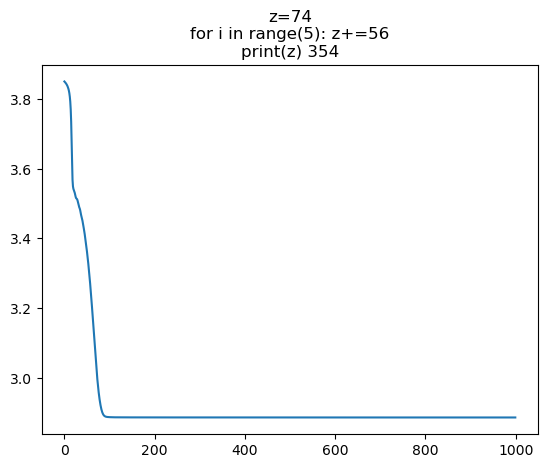

In [251]:
AxesSubplot = sns.lineplot(loss_values)
_ = AxesSubplot.set(title=f"{x} {y}")

In [229]:
torch.log(torch.tensor(vocab_size))

tensor(3.8501)

In [256]:
sample, target = x_t, y_t
outputs = []
for char_pos in range(sample.size(1)):
    output = model(sample[:, char_pos, :].squeeze())
outputs.append(output)

for char_pos in range(target.size(1) - 1):
    output = model(target[:, char_pos, :].squeeze())
    outputs.append(output)

In [263]:
idx_outputs = [torch.argmax(o).item() for o in outputs]
str_output = ''.join([pos2token[idx] for idx in idx_outputs])
print(str_output)

354


In [ ]:
def valid():
    pass

In [ ]:
main()